# Data analysis & data preprocessing

In [1]:
#!sed s/"'"/""/g BASE_BN_CASH_SALE_2CONTACT_20191219.csv > BASE_BN_CASH_SALE_2CONTACT_20191219_raw.csv ##to remove ' character 

In [2]:
import pandas as pd 
import numpy as np
from plotnine import *

The features that according to the data dictionary are dates are listed.

In [3]:
#### params 
dates= [  'DateCalc', 'REP_DATE', 'FIRST_PROD_DATE',  'DATE_PENS_DOC', 'DATE_FIRST_KDV_WITHOUT_CEL', 'DATE_FIRST_KDV_CEL', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO', 
        'MIN_DATEFIRST_DB_CRCARDS', 'MIN_DATESTART_ALL_CRCARDS'] 
y_column= 'Target_30_90d'

In [4]:
# From csv to parquet due to Github's file restrictions  
#data_raw = pd.read_csv('BASE_BN_CASH_SALE_2CONTACT_20191219_raw.csv', sep='\t', low_memory=False, infer_datetime_format=True, decimal=',')
#data_raw.to_parquet('BASE_BN_CASH_SALE_2CONTACT_20191219_raw.parquet', index=False)
data_raw = pd.read_parquet('BASE_BN_CASH_SALE_2CONTACT_20191219_raw.parquet')
data_raw

,TYPE_BASE,REP_CLID,REP_DATE,DateCalc,Target_30_90d,CONTACT_DAY_OF_WEEK,CONTACT_HOUR,FL_4P,P24_DATREG,P24_LEDATE,...,QTY_CALL_BN_NO_3M,QTY_CALL_BN_NO_1M,QTY_CALL_BN_ALL_3M,QTY_CALL_BN_ALL_1M,PRC_CALL_BN_OK_TO_ALL_3M,PRC_CALL_BN_OK_TO_ALL_1M,QTY_AFTER_CALL_BN_OK_3M,QTY_AFTER_CALL_BN_OK_1M,QTY_AFTER_CALL_OC_NF_O2_3M,QTY_AFTER_CALL_OC_NF_O2_1M
0,train,22181,2019-01-26,2019-01-01,0.0,7.0,16.0,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train,22181,None,2019-12-01,NaN,NaN,NaN,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train,22182,None,2019-12-01,NaN,NaN,NaN,N,2011-09-19,2019-10-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,train,22182,2019-03-17,2019-03-01,0.0,1.0,18.0,N,2012-05-31,2019-02-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,train,22182,2019-05-31,2019-05-01,1.0,6.0,18.0,N,2011-09-27,2019-04-24,...,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115076,train,60211,None,2019-12-01,NaN,NaN,NaN,N,2019-11-24,None,...,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
115077,train,60212,None,2019-12-01,NaN,NaN,NaN,N,None,None,...,0.0,0.0,1.0,1.0,100.0,100.0,NaN,NaN,1.0,1.0
115078,train,60213,None,2019-12-01,NaN,NaN,NaN,N,2019-11-24,None,...,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
115079,train,60214,None,2019-12-01,NaN,NaN,NaN,N,2019-11-24,None,...,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0


We note that we are working with an unbalanced dataset, so it will be convenient to use resampling techniques.

In [5]:
data_raw['Target_30_90d'].value_counts(dropna=False)

NaN    60215
0.0    48551
1.0     6315
Name: Target_30_90d, dtype: int64

We separate the dataset into _train_, _test_ and _validation_.
The _validation_ dataset will be used to measure the performance of the models trained with _train_, for reasons of time the _test_ set was not used.

In [6]:
nulos = data_raw['Target_30_90d'].isna()
test = data_raw[nulos].copy()
train = data_raw[~nulos].copy()

To decide which periods will be included in building the model the objective function on monthly windows with its respective 95% confidence interval.

/Users/antonio/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_count : Removed 60215 rows containing non-finite values.


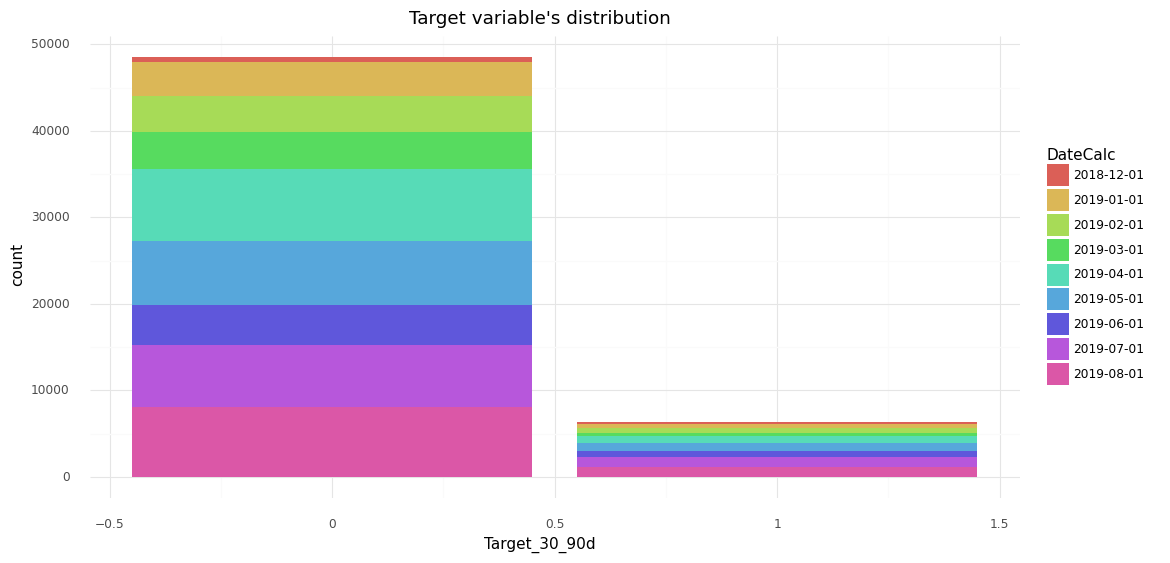

<ggplot: (346101959)>

In [7]:
(ggplot(data_raw, aes(x=y_column,  fill='DateCalc'))  + geom_bar() +  theme_minimal() + theme (figure_size=(12, 6) )  ) + \
ggtitle("Target variable's distribution")

In [8]:
temp = data_raw[['DateCalc', 'REP_CLID', 'TYPE_BASE' ]].groupby(['DateCalc', 'REP_CLID'])['TYPE_BASE'].aggregate('count')
temp = pd.DataFrame(temp).reset_index()
temp 

,DateCalc,REP_CLID,TYPE_BASE
0,2018-12-01,19,1
1,2018-12-01,243,1
2,2018-12-01,305,1
3,2018-12-01,334,1
4,2018-12-01,490,1
...,...,...,...
115076,2019-12-01,60211,1
115077,2019-12-01,60212,1
115078,2019-12-01,60213,1
115079,2019-12-01,60214,1


### We noted that there are no clients contacted more than once in the same month.

In [9]:
temp['TYPE_BASE'].value_counts() 

1    115081
Name: TYPE_BASE, dtype: int64

Next, the response variable is explored through the months. It should be noted that although the __number of contacts increased in the months of  May and June__, the same behavior __is not observed in the number of loan applications__.
In fact the number of applications is quite _stable_ on the data. 

In [10]:
import scipy.stats as st
temp =pd.DataFrame(columns=['DateCalc', 'P_target', 'std', 'P_25', 'P_975'])
temp['P_target'] = temp['std'] = temp['P_25'] = temp['P_975'] = [ -1 for _ in  range(len(train.DateCalc.unique())) ]
for i in range(len(train.DateCalc.unique())):
    _ = train.DateCalc.unique()[i]
    slide= train[train.DateCalc == _]
    c_i = st.norm.interval(alpha=0.95, loc=np.mean(slide[y_column]), scale=st.sem(slide[y_column]))
    temp.loc[i, 'DateCalc'] = _
    temp.loc[i, 'P_target'] = np.mean(slide[y_column])
    temp.loc[i, 'std'] = st.sem(slide[y_column])
    temp.loc[i, 'P_25'] = c_i[0]
    temp.loc[i,'P_975']= c_i[1]
    temp.loc[i,'suma'] = np.sum(slide[y_column])
    temp.loc[i, 'count'] = len(slide[y_column])
temp['Length_CI'] = temp.P_975 -temp.P_25
temp.sort_values(by='Length_CI')

,DateCalc,P_target,std,P_25,P_975,suma,count,Length_CI
6,2019-04-01,0.085958,0.002931,0.080212,0.091704,786.0,9144.0,0.011491
2,2019-05-01,0.102782,0.003347,0.096221,0.109343,846.0,8231.0,0.013122
3,2019-08-01,0.122427,0.003421,0.115722,0.129132,1124.0,9181.0,0.013410
4,2019-07-01,0.139538,0.003783,0.132124,0.146952,1171.0,8392.0,0.014828
1,2019-03-01,0.085435,0.004122,0.077356,0.093513,393.0,4600.0,0.016157
5,2019-02-01,0.119368,0.004705,0.110147,0.128590,567.0,4750.0,0.018442
7,2019-06-01,0.141135,0.004742,0.131841,0.150429,761.0,5392.0,0.018588
0,2019-01-01,0.118994,0.004875,0.109439,0.128549,525.0,4412.0,0.019110
8,2018-12-01,0.185864,0.014083,0.158262,0.213465,142.0,764.0,0.055203


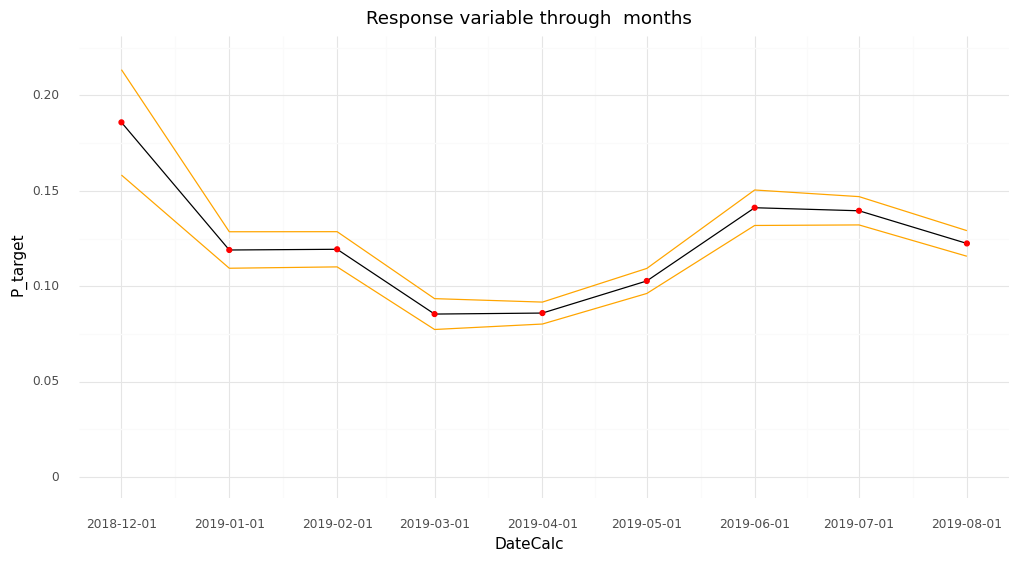

<ggplot: (351970804)>

In [11]:
temp.DateCalc = pd.to_datetime(temp.DateCalc)
ggplot(temp, aes(x='DateCalc', y='P_target') ) + geom_line() + geom_point(color='red')+ geom_line(aes(y='P_25'), color='orange') + \
geom_line(aes(y='P_975'), color='orange') + theme_minimal() + theme (figure_size=(12, 6) ) + ggtitle("Response variable through  months")+ ylim([0, .22])

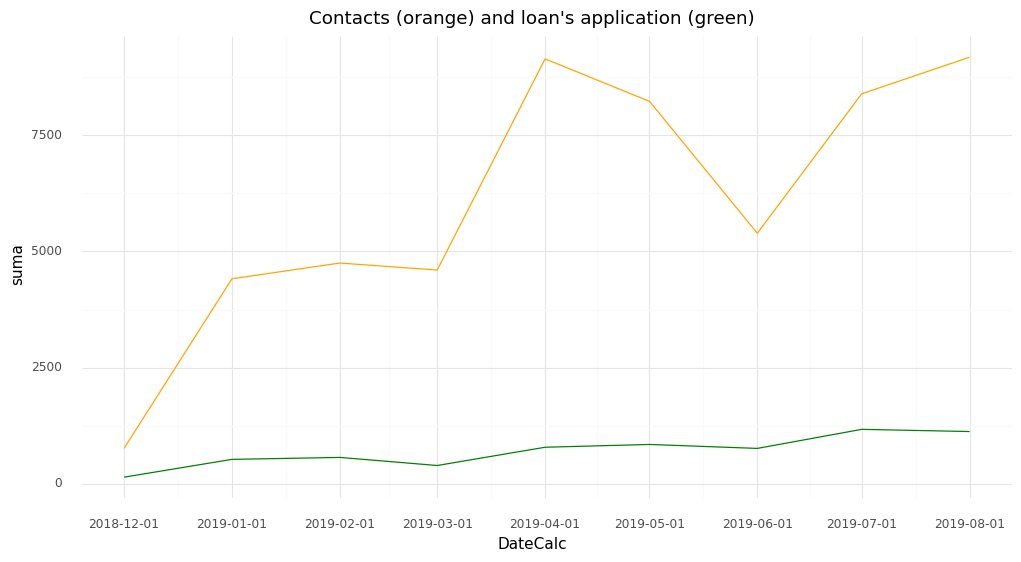

<ggplot: (351995513)>

In [12]:
temp.DateCalc= pd.to_datetime(temp.DateCalc)
ggplot(temp, aes(x='DateCalc', y='suma') ) + geom_line(color='green') + geom_line(aes(y='count'), color='orange') + \
 theme_minimal() + theme (figure_size=(12, 6) ) + ggtitle("Contacts (orange) and loan's application (green)")

Given what was observed in the two previous graphs, the stability of the response variable (i.e. its confidence interval does not increase) even with the increase in contacts in April and June, __it is decided to work with the records after February.__

In [13]:
train.REP_DATE = pd.to_datetime(train.REP_DATE) 
train['REP_DATE_month'] = train.REP_DATE.dt.month
temp =pd.DataFrame(columns=[ 'REP_DATE_month', 'P_target', 'std', 'P_25', 'P_975', 'suma', 'count'])
temp['P_target'] = temp['std'] = temp['P_25'] = temp['P_975'] = [ -1 for _ in  range(len(train.REP_DATE_month.unique())) ]
for i in range(len(train.REP_DATE_month.unique())):
    _ = train.REP_DATE_month.unique()[i]
    slide= train[train.REP_DATE_month == _]
    c_i = st.norm.interval(alpha=0.9, loc=np.mean(slide[y_column]), scale=st.sem(slide[y_column]))
    temp.loc[i, 'REP_DATE_month'] = _
    temp.loc[i, 'P_target'] = np.mean(slide[y_column])
    temp.loc[i, 'std'] = st.sem(slide[y_column])
    temp.loc[i, 'P_25'] = c_i[0]
    temp.loc[i,'P_975']= c_i[1]
    temp.loc[i,'suma'] = np.sum(slide[y_column])
    temp.loc[i, 'count'] = len(slide[y_column])
temp['Length_CI'] = temp.P_975 -temp.P_25
table1_1= temp.copy()
temp.sort_values(by='Length_CI')

,REP_DATE_month,P_target,std,P_25,P_975,suma,count,Length_CI
2,5,0.094752,0.003037,0.089755,0.099748,881.0,9298,0.009992
3,8,0.124379,0.003055,0.119355,0.129403,1452.0,11674,0.010048
6,4,0.094807,0.003175,0.089584,0.100030,807.0,8512,0.010446
4,7,0.145403,0.003842,0.139083,0.151723,1224.0,8418,0.012640
1,3,0.082219,0.004363,0.075043,0.089396,326.0,3965,0.014353
5,2,0.128276,0.004882,0.120246,0.136306,602.0,4693,0.016060
7,6,0.123408,0.005005,0.115175,0.131641,533.0,4319,0.016466
0,1,0.122899,0.005200,0.114346,0.131453,490.0,3987,0.017108


The following two graphs show the same previous analysis only considering the date of contact for it, however their interpretation reinforces the decision to work only with records after February.

In [14]:
index = train.REP_DATE <= '2019-01-01'
index.sum()

0

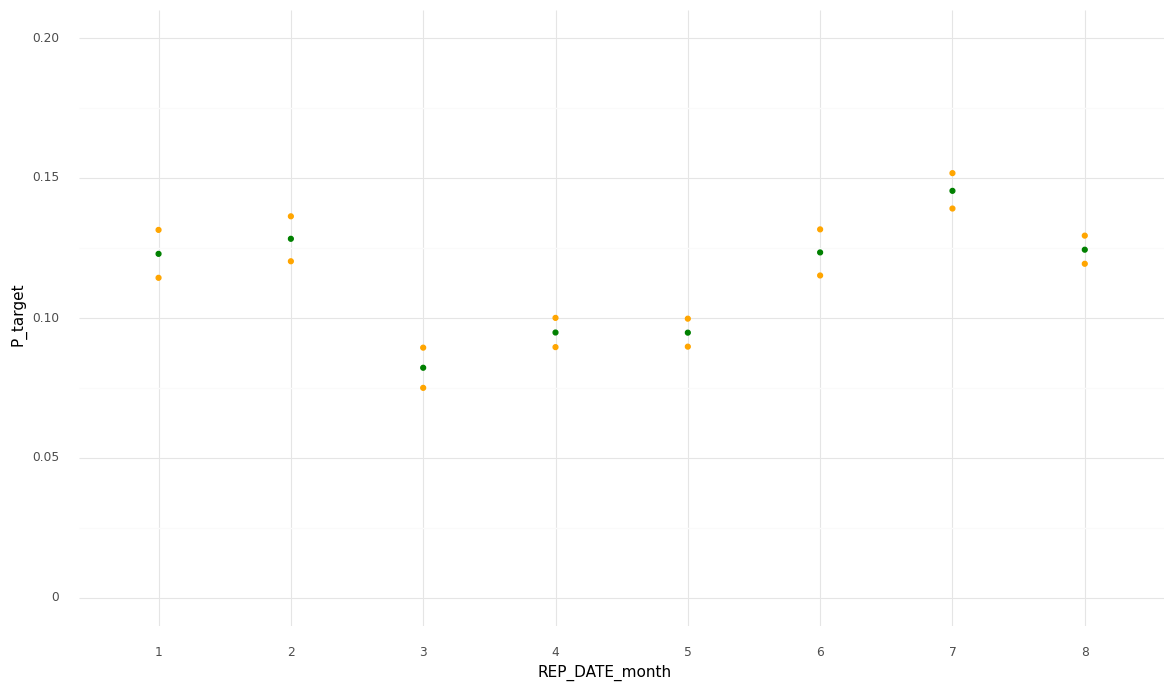

<ggplot: (351992263)>

In [15]:
ggplot(temp, aes(x='REP_DATE_month', y='P_target') ) + geom_point(color='green')  + geom_point(aes(y='P_25'), color='orange') + \
geom_point(aes(y='P_975'), color='orange') + theme_minimal() + theme (figure_size=(14, 8) ) + ylim([0, .20])

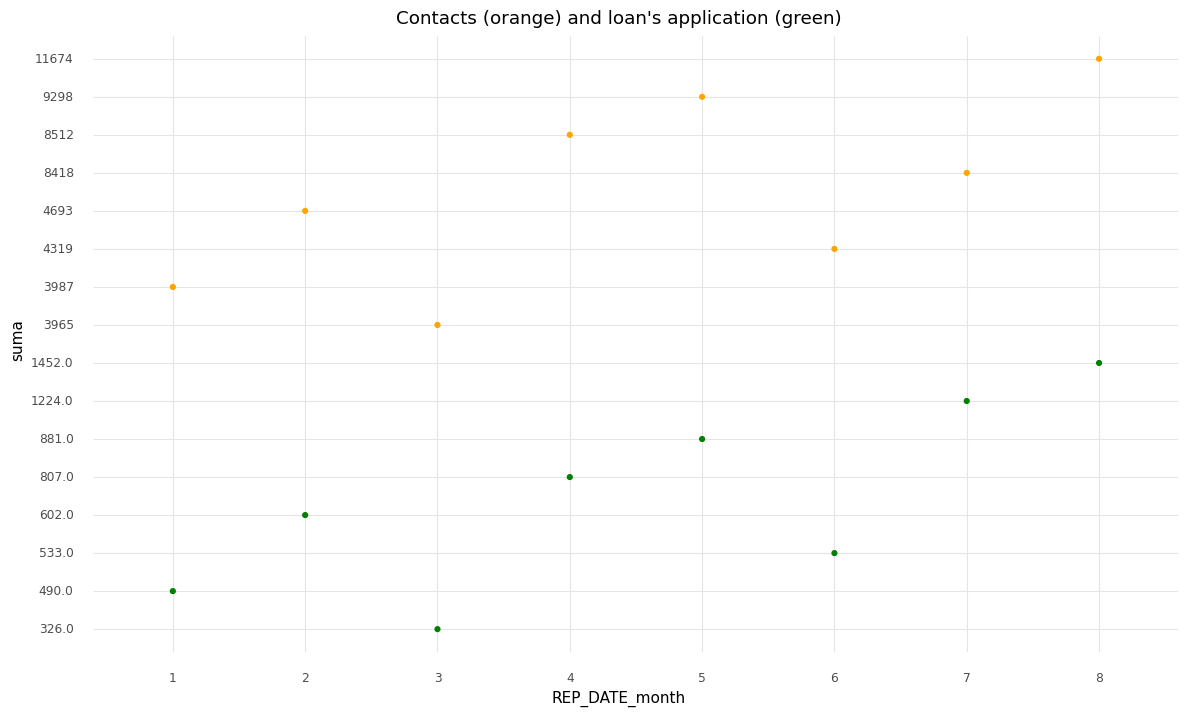

<ggplot: (352099118)>

In [16]:
ggplot(temp, aes(x='REP_DATE_month', y='suma') )  + geom_point(color='green')+  geom_point(aes(y='count'), color='orange') + theme_minimal() + \
theme(figure_size=(14, 8) ) + ggtitle("Contacts (orange) and loan's application (green)")

Table requiered on 1.1

In [17]:
table1_1

,REP_DATE_month,P_target,std,P_25,P_975,suma,count,Length_CI
0,1,0.122899,0.005200,0.114346,0.131453,490.0,3987,0.017108
1,3,0.082219,0.004363,0.075043,0.089396,326.0,3965,0.014353
2,5,0.094752,0.003037,0.089755,0.099748,881.0,9298,0.009992
3,8,0.124379,0.003055,0.119355,0.129403,1452.0,11674,0.010048
4,7,0.145403,0.003842,0.139083,0.151723,1224.0,8418,0.012640
5,2,0.128276,0.004882,0.120246,0.136306,602.0,4693,0.016060
6,4,0.094807,0.003175,0.089584,0.100030,807.0,8512,0.010446
7,6,0.123408,0.005005,0.115175,0.131641,533.0,4319,0.016466


Features with all null entries that are not present in both datasets are removed.

In [18]:
for _ in dates:
    data_raw[_] = pd.to_datetime(data_raw[_])
    data_raw[_] = data_raw[_].dt.date
to_remove =[]
index = data_raw.isna().sum() == data_raw.shape[0]
temp = data_raw.isna().sum()[index]
for _ in temp.index:
    to_remove.append(_)
    
    
del data_raw
import gc 
gc.collect()
index = train.DateCalc == '2019-08-01'
validation = train[index].copy()
train = train[~index].copy()
train = train[train.DateCalc >= '2019-03-01'].copy()


index = train.isna().sum() == train.shape[0]
temp = train.isna().sum()[index]
for _ in temp.index:
    to_remove.append(_)
    
index = validation.isna().sum() == validation.shape[0]
temp = validation.isna().sum()[index]
for _ in temp.index:
    to_remove.append(_)
    
    
to_remove = np.unique(to_remove)
print(to_remove)
for _ in to_remove:
    if _ not in ['REP_DATE', 'Target_30_90d']:
        del train[_]
        del validation[_]
        del test[_]
to_remove=[]

['AMT_DELAY_CRCARDS_CURR' 'AMT_MINPAY_CR_CURR_MONTH' 'P24_WEB_DAY_1M'
 'P24_WEB_DAY_6M' 'P24_WEB_ENTRY_1M' 'P24_WEB_ENTRY_6M'
 'P24_WEB_ENTRY_QTY' 'PRC_BAL_CURR_BAL_1_M_AGO' 'RAZN_BAL_REF_UBKI'
 'RAZN_COUN_REF_UBKI']


In [19]:
train.to_parquet('train.parquet' , index=False)
test.to_parquet('test.parquet', index=False)
validation.to_parquet('validation.parquet', index=False)